<a href="https://colab.research.google.com/github/m-walters/prob-ml/blob/main/examples/ex_3_3_3_bayes_gaussian_scalar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bayes rule for Gaussians
$$
p(z|\bf{y}) = N(z|\bf{u}_{z|y}, \bf{\Sigma}_{z|y})
$$
$$
\bf{\Sigma}_{z|y}^{-1} = \bf{\Sigma}_z^{-1} + \bf{W}^T\bf{\Sigma}_y^{-1}\bf{W}
$$
$$
\bf{\mu}_{z|y} = \bf{\Sigma}_{z|y}[\bf{W}^T\bf{\Sigma_y}^{-1}(\bf{y}-\bf{b}) + \bf{\Sigma}_z^{-1}\bf{\mu}_z]
$$
Gaussian prior is a conjugate of a Gaussian likelihood.


### Method 1, bulk measurements of constant accuracy

We have a hidden variable $z$, and we take $k$ noisy measurements $\{y_1, y_2,...\}$.

We will assume the measurements have a fixed precision $\lambda_y=1/\sigma^2$.

The likelihood is the gaussian
$$p(y_i|z) = N(y_i|z,\lambda_y^{-1}).$$

We can use the prior for the unknown source
$$p(z) = N(z|\mu_0, \lambda^{-1}_0),$$

and we want to compute $p(z|y_1,...,y_k, \sigma^2)$. See the text for the remainder of the explanation.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, TypedDict, List
from scipy.stats import multivariate_normal as mvn


np.random.seed(8675309)

In [ ]:
z, sigma_z = 5, 2
k = 5

mu_0 = 0
sigma_0, sigma_y = 3, 1  # our prior variance sigma_0 should be larger since we are uncertain
lam_0, lam_y = 1./sigma_0, 1./sigma_y


With a set of samples taken with a fixed measurement noise $\lambda_y$

In [ ]:
# Grab measurements y_i of z
z_dist = mvn(mean=z, cov=sigma_z)
y = z_dist.rvs(size=k)
prior = mvn(mean=mu_0, cov=sigma_0)

# We also grab the first likelihood
likelihood_1 = mvn(mean=y[0], cov=sigma_y)

W = np.ones((1,k))
Cov_y_inv = np.diag(lam_y*W.flatten())
lam_k = lam_0 + k*lam_y
mu_k = (k*lam_y/(k*lam_y+lam_0)) * np.mean(y) + (lam_0/(k*lam_y + lam_0)) * mu_0
posterior = mvn(mean=mu_k, cov=lam_k)

In [ ]:
def plot_data(quantiles, pdf_dict, variance_prior):
    """
    Plot data

    Args:
    ----------
    quantiles : array array
        Quantiles for normal distribution

    pdf_dict : dictionary
        Data and plotting options for pdfs

    variance_prior : int/float
        Variance of Prior

    """

    # Setup graph and parameters
    fig = plt.figure()

    # Plot graph
    for key, value in pdf_dict.items():
        plt.plot(
            quantiles,
            value["pdf"],
            color=value["color"],
            label=key,
            linestyle=value["linestyle"],
            linewidth=1.5,
            zorder=value.get("zorder", 0)
        )

    # Update labels,legends and title
    plt.title(f"Prior with variance of {variance_prior}")
    plt.xlabel("$x$")
    plt.ylabel("$p(x)$")
    plt.legend(loc="upper left")
    sns.despine()

    plt.show()

In [ ]:
quantiles = np.arange(-10, 10, 0.10)
# Setup data and graphing options
pdf_plot_dict = {
    "prior": {"pdf": prior.pdf(quantiles), "color": "blue", "linestyle": "-"},
    "likelihood": {"pdf": likelihood_1.pdf(quantiles), "color": "red", "linestyle": ":"},
    "posterior": {"pdf": posterior.pdf(quantiles), "color": "black", "linestyle": "-."},
}


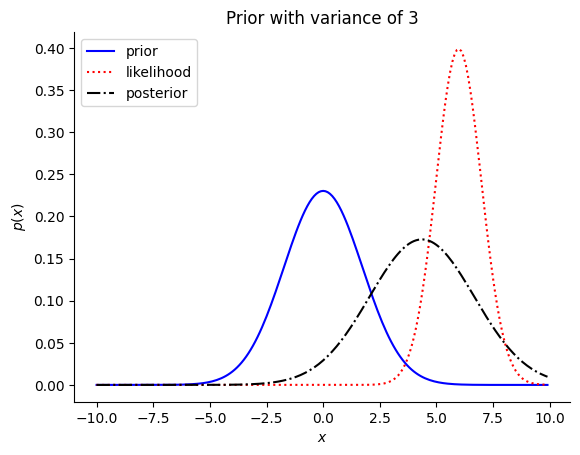

In [ ]:
plot_data(quantiles, pdf_plot_dict, sigma_0)

### Method 2 | Bayesian updating of prior

The last method didn't involve iterative bayesian updating.
It was like a shortcut to generating the posterior based on
$k$ measurements of constant accuracy $1/\sigma^{2}$.
As the text describes: "Having $k$ measurements with precision $\lambda_y$ is like having one measurement of value $\bar{y}$ with precision $k\lambda_y$.

We now apply the update rule provided on page 87 for consecutive measurements.

In [ ]:
k = 6
quantiles = np.arange(-10, 10, 0.1)
y = z_dist.rvs(size=k)
mu_0, sigma_0 = 0, 3
# Let's increase the noise
sigma_y = 5

pdf_plot_dict = {
    "prior 0": {
        "pdf": mvn.pdf(quantiles, mean=mu_0, cov=sigma_0),
        "color": "blue",
        "linestyle": ":",
        "zorder": k,
    }
}
for ik in range(k):
  y_i = y[ik]
  sigma = sigma_y*sigma_0/(sigma_0 + sigma_y)
  mu = sigma * (mu_0/sigma_0 + y_i/sigma_y)
  posterior_pdf = mvn.pdf(quantiles, mean=mu, cov=sigma)
  pdf_plot_dict[f"posterior {ik}"] = {
      "pdf": posterior_pdf, "color": [0.2, float(ik)/k, 0.2], "linestyle": "-",
      "zorder": k-ik-1
  }
  # Update prior as the posterior
  sigma_0 = sigma
  mu_0 = mu

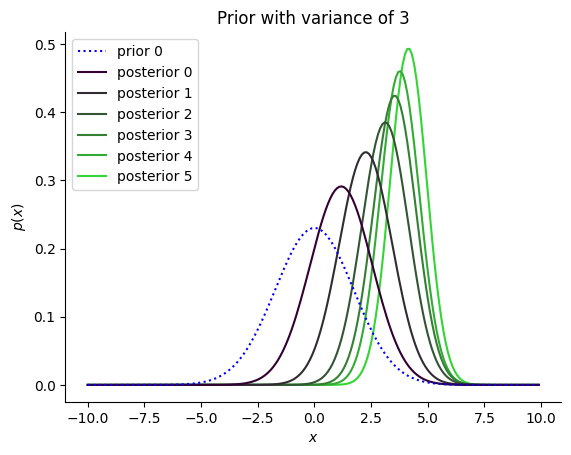

In [ ]:
plot_data(quantiles, pdf_plot_dict, 3)